In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import copy

In [2]:
#This function converts a CSV file to two numpy arrays for features and response
def csv_to_arrs(filename, response_name):
    #Importing CSV as Pandas dataframe
    dataframe = pd.read_csv(filename)
    
    #Splitting dataframe into x and y
    response = dataframe[response_name]
    features = dataframe.drop([response_name], axis=1)
    
    #Converting datagrames to numpy array
    response_arr = response.to_numpy(dtype='float64')
    features_arr = features.to_numpy()
    
    features_arr[features_arr == 'Male'] = 1
    features_arr[features_arr == 'Female'] = 0
    features_arr[features_arr == 'Yes'] = 1
    features_arr[features_arr == 'No'] = 0
    features_arr = features_arr.astype('float64')

    return list(dataframe.columns), features_arr, response_arr


#Function to center data
def center_data(data):
    #Finding the mean column-wise
    data_mean = np.mean(data, axis=0)
    cent_data = np.subtract(data, data_mean)
        
    return cent_data, data_mean


#Function to standardize data    
def normalize_data(data):
    #Finding the mean and standard deviation column-wise
    cent_data, data_mean = center_data(data)
    data_std = np.std(cent_data, axis=0)
    norm_data = np.divide(cent_data, data_std)

    return norm_data, data_mean, data_std

def elastic_net(x_train, y_train, lamb, alpha, epoch, verbose):
    beta = np.random.rand(x_train.shape[1], 1)-0.5
    
    x_norm, x_mean, x_std = normalize_data(x_train)
    y_cent, y_mean = center_data(y_train)
    
    x_norm_sq = np.power(x_norm, 2)
    b = np.sum(x_norm_sq, axis=0)
    
    for iteration in range(1, epoch+1):
        beta_prev = copy.deepcopy(beta)
        
        for k in range(x_train.shape[1]):
            x_k = x_norm[:,k]
            y_pred = np.matmul(x_norm, beta)
            y_pred = np.reshape(y_pred, y_cent.shape)
            residual = np.subtract(y_cent, y_pred)
            y_k = x_k*beta[k]
            residual = np.reshape(residual, y_k.shape)
            
            a = np.matmul(x_k.T, np.add(residual, y_k))
            
            ReLU = np.maximum(0, np.subtract(np.abs(a), 0.5*lamb*(1-alpha)))
            
            numerator = np.multiply(np.sign(a), ReLU)       
            denominator = np.add(b[k], lamb*alpha)
                          
            beta[k] = np.divide(numerator, denominator)
            
        comparison = beta_prev == beta
        if comparison.all():
            if verbose == 1:
                print(f'The model converged at epoch {iteration}')
            break
    
    return beta, x_mean, x_std, y_mean


#Finding the MSE of the regression algorithm
def evaluate_regression(beta, x_mean, x_std, y_mean, x_test, y_test):
    #Standardizing test feature set with training set values
    x_test = np.divide(np.subtract(x_test, x_mean), x_std)
    y_pred = np.matmul(x_test, beta)
    
    #Centering test response set with training set values
    y_test = np.subtract(y_test, y_mean)
    
    #Finding the MSE of the regression algorithm
    mse = (1/y_pred.shape[0])*(np.sum(pow(np.subtract(y_test, y_pred), 2)))
    
    return mse


#k-fold cross validation algorithm
def k_fold_cv(x, y, n, lamb, alpha, epoch):
    #An array to store the MSE of each run
    results = []
    
    #Zipping the data, shuffling it to randomize it, and then splitting the data into equal chunks
    data = np.column_stack((x, y))
    np.random.shuffle(data)
    data = np.split(data, n, axis=0)
    
    #For each split...
    for i, split in enumerate(data):
        #Separate response and feature validation sets from the ith split
        y_valid = split[:,-1]
        y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))   
        x_valid = np.delete(split, -1, axis=1)
        
        #Combine the remaining chunks
        train_data_list = data[:i] + data[i+1:]
        train_data = train_data_list[0]
        for j in range(1,len(train_data_list)):
            train_data = np.concatenate((train_data, train_data_list[j]), axis=0)
        
        #Separate response and feature training sets from the rest of the data
        y_train = train_data[:,-1]
        y_train = np.reshape(y_train, (y_train.shape[0],1))   
        x_train = np.delete(train_data, -1, axis=1)
        
        #Perform the regression and obtain beta values
        beta, x_mean, x_std, y_mean = elastic_net(x_train, y_train, lamb, alpha, epoch, 0)
        
        #Evaluate the regression
        error = evaluate_regression(beta, x_mean, x_std, y_mean, x_valid, y_valid)
        results.append(error)
    
    #Find the MSE of the k-fold cross validation
    cv_mse = (1/n)*(sum(results))
    
    return cv_mse, beta

The current parameter pair is (alpha = 0, lambda = 0.01)
The current parameter pair is (alpha = 0, lambda = 0.1)
The current parameter pair is (alpha = 0, lambda = 1)
The current parameter pair is (alpha = 0, lambda = 10)
The current parameter pair is (alpha = 0, lambda = 100)
The current parameter pair is (alpha = 0, lambda = 1000)
The current parameter pair is (alpha = 0, lambda = 10000)
The current parameter pair is (alpha = 0, lambda = 100000)
The current parameter pair is (alpha = 0, lambda = 1000000)
The current parameter pair is (alpha = 0.2, lambda = 0.01)
The current parameter pair is (alpha = 0.2, lambda = 0.1)
The current parameter pair is (alpha = 0.2, lambda = 1)
The current parameter pair is (alpha = 0.2, lambda = 10)
The current parameter pair is (alpha = 0.2, lambda = 100)
The current parameter pair is (alpha = 0.2, lambda = 1000)
The current parameter pair is (alpha = 0.2, lambda = 10000)
The current parameter pair is (alpha = 0.2, lambda = 100000)
The current paramete

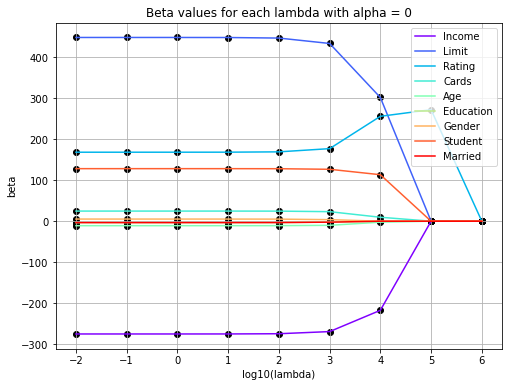

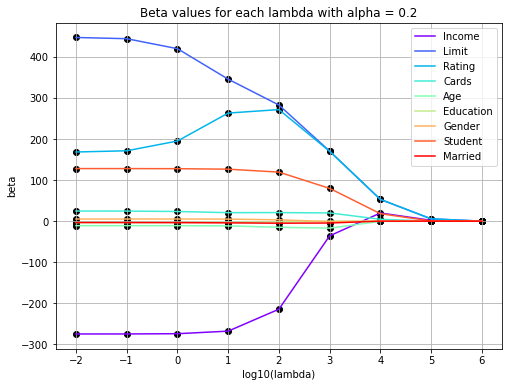

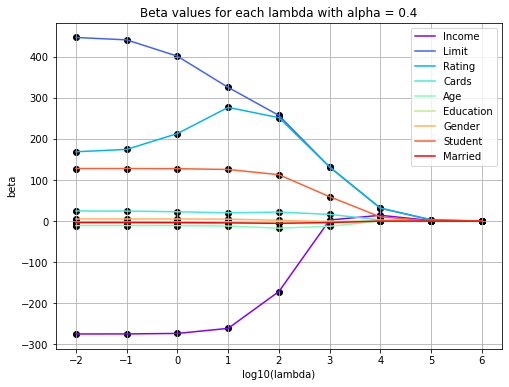

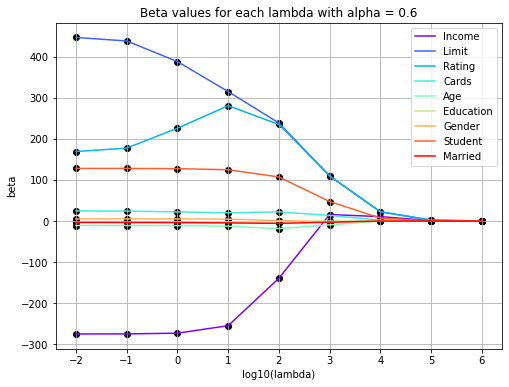

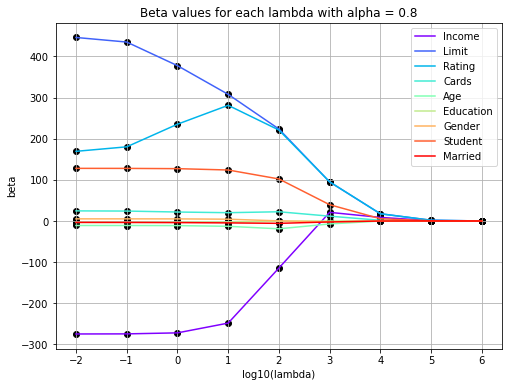

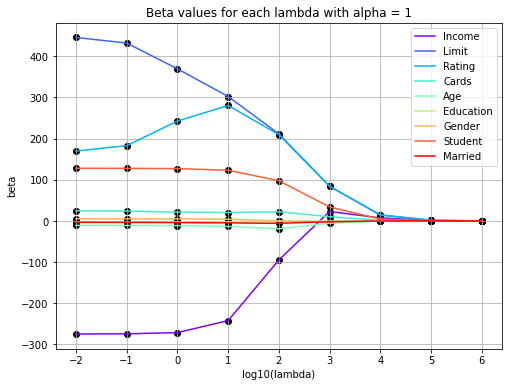

In [3]:
#Set the filepath here
filepath = 'Credit_N400_p9.csv'

#Getting the dataset from the CSV file
labels, x, y = csv_to_arrs(filepath, 'Balance')

#Setting some parameters to run the regression
alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]
epochs = 1000
mse_arr = []
beta_arr = []
lambs = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

lamb_fig_labels = labels[:-1]

for alpha in alphas:
    lamb_mse_arr = []
    lamb_beta_arr = []
    for lamb in lambs:
        print(f'The current parameter pair is (alpha = {alpha}, lambda = {lamb})')
        
        beta, _, _, _ = elastic_net(x, y, lamb, alpha, epochs, 0)
        mse, _ = k_fold_cv(x, y, 5, lamb, alpha, epochs)
        
        lamb_mse_arr.append(mse)
        lamb_beta_arr.append(beta)
    
    mse_arr.append(lamb_mse_arr)
    
    lamb_log = np.log10(lambs)
    lamb_log_smooth = np.linspace(lamb_log.min(), lamb_log.max(), 500)
    
    #Setting equally-spaced color values
    color_spacing = np.linspace(0,1,x.shape[1])
    colors = [cm.rainbow(lamb_log_smooth) for lamb_log_smooth in color_spacing]
    
    #Creating the figure
    fig0, ax0 = plt.subplots(figsize=[8,6])

    #For each feature i...
    for i in range(x.shape[1]):
        beta_i = []

        #For each lambda value...
        for j in range(len(lambs)):
            betas_for_lambda = lamb_beta_arr[j]

            #Append beta value for feature i to an array
            beta_i.append(betas_for_lambda[i])

        #Plotting the beta values for feature i for each lambda 
        ax0.plot(lamb_log, beta_i, label=lamb_fig_labels[i] , color=colors[i])
        ax0.scatter(lamb_log, beta_i, color='k')
        ax0.set_title(f'Beta values for each lambda with alpha = {alpha}')
        
    ax0.set_xlabel('log10(lambda)')
    ax0.set_ylabel('beta')
    ax0.legend(lamb_fig_labels,loc='upper right')
    ax0.grid()

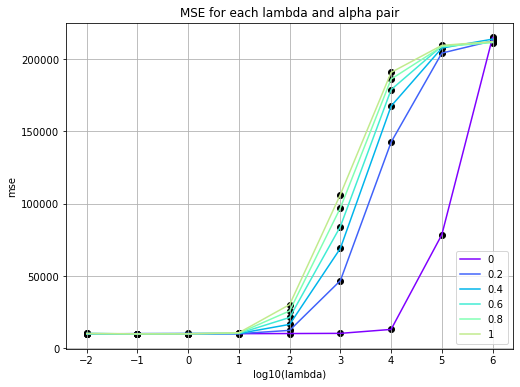

In [5]:
lamb_log = np.log10(lambs)
lamb_log_smooth = np.linspace(lamb_log.min(), lamb_log.max(), 500)

alpha_labels = [str(alpha) for alpha in alphas]

#Setting equally-spaced color values
color_spacing = np.linspace(0,1,x.shape[1])
colors = [cm.rainbow(lamb_log_smooth) for lamb_log_smooth in color_spacing]

fig1, ax1 = plt.subplots(figsize=[8,6])

for i, mse in enumerate(mse_arr):
    ax1.plot(lamb_log, mse, label=alpha_labels[i] , color=colors[i])
    ax1.scatter(lamb_log, mse, color='k')

ax1.set_title('MSE for each lambda and alpha pair')
ax1.set_xlabel('log10(lambda)')
ax1.set_ylabel('mse')
ax1.legend(alpha_labels, loc='lower right')
ax1.grid()

In [6]:
best_pairs = []
best_mses = []

for i, mse in enumerate(mse_arr):
    best_pairs.append((alphas[i], lambs[mse.index(min(mse))]))
    best_mses.append(round(min(mse),2))
    
    print(f'For alpha = {alphas[i]} the lambda value with the best MSE is lambda = {lambs[mse.index(min(mse))]} with MSE = {round(min(mse),2)}\n')

best_pair = best_pairs[best_mses.index(min(best_mses))]

print(f'\n\nThe overall best pair is (alpha = {best_pair[0]}, lambda = {best_pair[1]})')

For alpha = 0 the lambda value with the best MSE is lambda = 0.1 with MSE = 9940.38

For alpha = 0.2 the lambda value with the best MSE is lambda = 0.01 with MSE = 9887.33

For alpha = 0.4 the lambda value with the best MSE is lambda = 0.1 with MSE = 9889.98

For alpha = 0.6 the lambda value with the best MSE is lambda = 0.1 with MSE = 9918.72

For alpha = 0.8 the lambda value with the best MSE is lambda = 0.01 with MSE = 9983.26

For alpha = 1 the lambda value with the best MSE is lambda = 0.1 with MSE = 9936.51



The overall best pair is (alpha = 0.2, lambda = 0.01)


In [8]:
best_lambda_a0 = best_pairs[0][1]

best_lambda_a1 = best_pairs[-1][1]

#Generating betas for alpha = 0
beta_a0, _, _, _= elastic_net(x, y, best_lambda_a0, 0, 10000, 0)

#Generating betas for alpha = 1
beta_a1, _, _, _= elastic_net(x, y, best_lambda_a1, 1, 10000, 0)

#Generating betas for best pair
beta_best, _, _, _= elastic_net(x, y, best_pair[1], best_pair[0], 10000, 0)

print(f'The betas for lasso regression with lambda = {best_lambda_a0} are:\n{beta_a0}\n\n')

print(f'The betas for ridge regression with lambda = {best_lambda_a1} are:\n{beta_a1}\n\n')

print(f'The betas for alpha = {best_pair[0]} and lambda = {best_pair[1]} are:\n{beta_best}')

The betas for lasso with lambda = 0.1 are:
[[-274.63134089]
 [ 445.1009296 ]
 [ 170.33516645]
 [  24.5468501 ]
 [ -10.93427046]
 [  -3.48020134]
 [   5.199996  ]
 [ 127.94060368]
 [  -3.41945777]]



The betas for ridge with lambda = 0.1 are:
[[-274.30439375]
 [ 430.60643833]
 [ 184.52205981]
 [  23.94169587]
 [ -10.97597645]
 [  -3.40063905]
 [   5.18996712]
 [ 127.81260569]
 [  -3.52295036]]



The betas for alpha = 0.2 and lambda = 0.01 are:
[[-274.62539204]
 [ 444.77971099]
 [ 170.65087878]
 [  24.53346412]
 [ -10.93522128]
 [  -3.47855878]
 [   5.19992509]
 [ 127.93798552]
 [  -3.42184498]]


Overall, the beta values are very similar with many of them falling within a difference of 0.1. However, the beta values obtained from the elastic net algorithm fall between both ridge and lasso regression. This implies that there is regularization being applied to the model, allowing for more nuanced or fitted models. The values from the best alpha most align with those from lasso regression due to the fact that the alpha value is close to 0. Lastly, the effect of lambda is clear on the models. 
Since all of the models share a very low lambda value, there is no feature selection being applied as there are no beta values that have been forced to 0.